In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
from nsepython import *
import itertools
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#NIFTY 50 Universe
nifty_50_ticker_url = 'https://www1.nseindia.com/content/indices/ind_nifty50list.csv'
nifty_50 = pd.read_csv(nifty_50_ticker_url)

In [3]:
'''priceDataYearly = {}
for ticker in nifty_50.Symbol:
    priceDataYearly[ticker] = nse_eq(ticker)['priceInfo']['weekHighLow']
price_df = pd.DataFrame(priceDataYearly).T
price_df.to_csv('ticker_52w_price_data.csv')'''

"priceDataYearly = {}\nfor ticker in nifty_50.Symbol:\n    priceDataYearly[ticker] = nse_eq(ticker)['priceInfo']['weekHighLow']\nprice_df = pd.DataFrame(priceDataYearly).T\nprice_df.to_csv('ticker_52w_price_data.csv')"

In [4]:
price_df = pd.read_csv('ticker_52w_price_data.csv', index_col=0)

In [5]:
#Downloading historic data from yfinance
historic_price = yf.download((nifty_50.Symbol + '.NS').to_list(), progress=True)['Adj Close']

[*********************100%***********************]  50 of 50 completed


In [6]:
#calculate 200 days moving average
moving_avg = historic_price.rolling(200).mean()

In [7]:
#Creating a dictionary of data with Ticker as the Key and merged df as value
final_data = {}
for ticker in nifty_50.Symbol:
    ticker = ticker + '.NS'
    merged_df = pd.merge(historic_price[ticker], moving_avg[ticker], left_index=True, right_index=True)
    merged_df.columns = ['Adj Close', '200MA']
    merged_df['distance'] = merged_df['Adj Close'] - merged_df['200MA']#((merged_df['Adj Close'] - merged_df['200MA'])*100)/merged_df['200MA']
    data_dict = {
        'price_df': merged_df,
        '52w_data' : price_df.loc[ticker.split('.')[0]]
    }
    final_data[ticker] = data_dict

In [66]:
txns_new = []

In [67]:
def backtest(stoploss, profit_cap):

    cum_pnl = 0
    txns = []

    #condition 1
    #Adj Close value between 20-60%
    for ticker in final_data:
        df = final_data[ticker]['price_df']
        df = df.iloc[-1250:,:]
        df['52w_max'] = np.nan
        df['52w_min'] = np.nan
        df['diff'] = np.nan
        df['top_5'] = np.nan

        for i in range(len(df)):
            # slice the dataframe to get the last 250 rows
            sliced_df = df.iloc[max(0, i-250):i+1]
            # calculate the maximum and minimum price in the sliced dataframe
            max_price = sliced_df['Adj Close'].max()
            min_price = sliced_df['Adj Close'].min()
            diff = max_price - min_price
            # do something with the maximum and minimum price
            df.iloc[i,3] = max_price
            df.iloc[i,4] = min_price
            df.iloc[i,5] = diff
            df.iloc[i,6] = df.iloc[i,2] < np.percentile(sliced_df.distance, 5)

        state = 'out'  # state can be 'out', 'long' or 'short'
        profit = 0
        stop_loss = 0
        
        for index, row in df.iterrows():
        # check if the state is 'out' and the current price goes below 200MA
            if state == 'out' and ((row['Adj Close'] > (row['52w_min'] + 0.2* row['diff'])) & (row['Adj Close'] < (row['52w_min'] + 0.8*row['diff']))) & (row['200MA'] > row['Adj Close']) & (row['top_5']):
                state = 'long'
                buy_price = row['Adj Close']
                stop_loss = buy_price * (1-stoploss)
                print('Bought {} on {} at {}'.format(ticker, index, buy_price))
            
            # check if the state is 'long' and the current price goes below stop loss
            if state == 'long' and row['Adj Close'] < stop_loss:
                state = 'out'
                sell_price = row['Adj Close']
                profit = sell_price - buy_price
                cum_pnl += profit
                txns_new.append([index, ticker, profit])
                print('Sold {} on {} at {} for a profit of {}'.format(ticker, index, sell_price, profit))
            
            # check if the state is 'long' and the profit is more than 20%
            if state == 'long' and (row['Adj Close'] - buy_price) / buy_price > profit_cap:
                state = 'out'
                sell_price = row['Adj Close']
                profit = sell_price - buy_price
                cum_pnl += profit
                txns_new.append([index, ticker, profit])
                print('Sold {} on {} at {} for a profit of {}'.format(ticker, index, sell_price, profit))
    print('final profit/loss is rs: {}'.format(cum_pnl))
    return sl_prof_ret.append([stoploss, profit_cap ,cum_pnl])


In [49]:
sl_prof_ret = []

In [68]:
backtest(0.15, 0.29)

C:\Users\singh\AppData\Local\Temp\ipykernel_57932\3194195789.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['52w_max'] = np.nan
C:\Users\singh\AppData\Local\Temp\ipykernel_57932\3194195789.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['52w_min'] = np.nan
C:\Users\singh\AppData\Local\Temp\ipykernel_57932\3194195789.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Bought ADANIENT.NS on 2019-04-30 00:00:00 at 125.60789489746094
Sold ADANIENT.NS on 2019-10-18 00:00:00 at 173.63926696777344 for a profit of 48.0313720703125
Bought ADANIENT.NS on 2020-03-13 00:00:00 at 147.5090789794922
Sold ADANIENT.NS on 2020-03-23 00:00:00 at 120.76846313476562 for a profit of -26.740615844726562
Bought ADANIENT.NS on 2022-02-24 00:00:00 at 1543.2939453125
Sold ADANIENT.NS on 2022-03-30 00:00:00 at 1994.4022216796875 for a profit of 451.1082763671875
Bought ADANIENT.NS on 2023-01-27 00:00:00 at 2761.449951171875
Sold ADANIENT.NS on 2023-02-01 00:00:00 at 2135.35009765625 for a profit of -626.099853515625
Bought ADANIENT.NS on 2023-02-08 00:00:00 at 2164.25
Bought ADANIPORTS.NS on 2020-02-24 00:00:00 at 353.34979248046875
Sold ADANIPORTS.NS on 2020-03-12 00:00:00 at 280.5826721191406 for a profit of -72.76712036132812
Bought ADANIPORTS.NS on 2020-03-25 00:00:00 at 252.0755157470703
Sold ADANIPORTS.NS on 2020-05-28 00:00:00 at 327.22479248046875 for a profit of 75.1

In [50]:
sl = [0.05, 0.08, 0.1, 0.12, 0.15]
prof = np.arange(0.05,0.30, 0.03)
for sl_val, prof_val in itertools.product(sl,prof):
    backtest(sl_val, prof_val)

C:\Users\singh\AppData\Local\Temp\ipykernel_57932\1600364906.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['52w_max'] = np.nan
C:\Users\singh\AppData\Local\Temp\ipykernel_57932\1600364906.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['52w_min'] = np.nan
C:\Users\singh\AppData\Local\Temp\ipykernel_57932\1600364906.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Bought ADANIENT.NS on 2019-04-30 00:00:00 at 125.60789489746094
Sold ADANIENT.NS on 2019-05-09 00:00:00 at 118.73677825927734 for a profit of -6.871116638183594
Bought ADANIENT.NS on 2019-05-10 00:00:00 at 118.6379165649414
Sold ADANIENT.NS on 2019-05-20 00:00:00 at 150.22525024414062 for a profit of 31.58733367919922
Bought ADANIENT.NS on 2019-07-19 00:00:00 at 129.90850830078125
Sold ADANIENT.NS on 2019-09-06 00:00:00 at 136.60084533691406 for a profit of 6.6923370361328125
Bought ADANIENT.NS on 2020-03-13 00:00:00 at 147.5090789794922
Sold ADANIENT.NS on 2020-03-16 00:00:00 at 133.57630920410156 for a profit of -13.932769775390625
Bought ADANIENT.NS on 2022-02-24 00:00:00 at 1543.2939453125
Sold ADANIENT.NS on 2022-02-28 00:00:00 at 1643.751220703125 for a profit of 100.457275390625
Bought ADANIENT.NS on 2022-03-07 00:00:00 at 1563.385498046875
Sold ADANIENT.NS on 2022-03-09 00:00:00 at 1655.84619140625 for a profit of 92.460693359375
Bought ADANIENT.NS on 2023-01-27 00:00:00 at 276

In [51]:
sl_prof_ret

[[0.05, 0.05, 6750.62308883667],
 [0.05, 0.08, 4096.976650238037],
 [0.05, 0.11, 3204.242275238037],
 [0.05, 0.14, 5686.458358764648],
 [0.05, 0.16999999999999998, 8226.137924194336],
 [0.05, 0.2, 10193.141330718994],
 [0.05, 0.22999999999999998, 9154.638660430908],
 [0.05, 0.26, 12085.872463226318],
 [0.05, 0.29, 13504.865184783936],
 [0.08, 0.05, 5034.2971534729],
 [0.08, 0.08, 4826.560932159424],
 [0.08, 0.11, 3769.876552581787],
 [0.08, 0.14, 7646.582336425781],
 [0.08, 0.16999999999999998, 9446.24796295166],
 [0.08, 0.2, 12010.842121124268],
 [0.08, 0.22999999999999998, 11058.552394866943],
 [0.08, 0.26, 13707.249332427979],
 [0.08, 0.29, 14496.669368743896],
 [0.1, 0.05, 4223.638111114502],
 [0.1, 0.08, 2894.784755706787],
 [0.1, 0.11, 1460.4304237365723],
 [0.1, 0.14, 5904.904991149902],
 [0.1, 0.16999999999999998, 7810.4357986450195],
 [0.1, 0.2, 10036.397296905518],
 [0.1, 0.22999999999999998, 9431.38268661499],
 [0.1, 0.26, 12053.68632888794],
 [0.1, 0.29, 13966.788944244385]

In [53]:
combn_df = pd.DataFrame(sl_prof_ret, columns=['Stop Loss', 'Profit Target', 'PnL'])

In [58]:
combn_df.sort_values(by='PnL', ascending=False).reset_index(drop=True)

,Stop Loss,Profit Target,PnL
0,0.15,0.29,17987.497410
1,0.12,0.29,16521.422253
2,0.15,0.26,16098.603252
3,0.12,0.26,15943.672115
4,0.15,0.20,14923.954540
5,0.12,0.20,14768.813145
6,0.08,0.29,14496.669369
7,0.15,0.23,14247.581745
8,0.10,0.29,13966.788944
9,0.12,0.23,13914.277996


In [69]:
txns_df = pd.DataFrame(txns_new, columns=['Date', 'Ticker', 'Profit']).set_index('Date')

In [70]:
txns_df

,Ticker,Profit
Date,,
2019-10-18,ADANIENT.NS,48.031372
2020-03-23,ADANIENT.NS,-26.740616
2022-03-30,ADANIENT.NS,451.108276
2023-02-01,ADANIENT.NS,-626.099854
2020-03-12,ADANIPORTS.NS,-72.767120
...,...,...
2022-03-03,ULTRACEMCO.NS,-1168.591309
2022-06-13,ULTRACEMCO.NS,-944.328613
2020-03-09,WIPRO.NS,-42.828094


<AxesSubplot: xlabel='Date'>

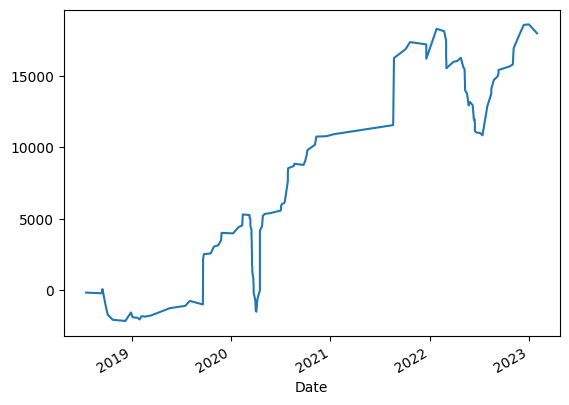

In [72]:
txns_df.sort_index().Profit.cumsum().plot()

------

In [ ]:
df = []
df = final_data['BHARTIARTL.NS']['price_df']
df['52w_max'] = np.nan
df['52w_min'] = np.nan
df['diff'] = np.nan
df['top_5'] = np.nan
df['buy'] = np.nan
df['sell'] = np.nan
df['cum_pnl'] = np.nan

df

In [ ]:
for i in range(len(df)):
    # slice the dataframe to get the last 250 rows
    sliced_df = df.iloc[max(0, i-250):i+1]
    # calculate the maximum and minimum price in the sliced dataframe
    max_price = sliced_df['Adj Close'].max()
    min_price = sliced_df['Adj Close'].min()
    diff = max_price - min_price
    # do something with the maximum and minimum price
    df.iloc[i,3] = max_price
    df.iloc[i,4] = min_price
    df.iloc[i,5] = diff
    df.iloc[i,6] = df.iloc[i,2] < np.percentile(sliced_df.distance, 5)
    


In [ ]:
df

In [ ]:
state = 'out'  # state can be 'out', 'long' or 'short'
profit = 0
stop_loss = 0
cum_pnl = 0

In [ ]:
for index, row in df.iterrows():
    # check if the state is 'out' and the current price goes below 200MA
    if state == 'out' and ((row['Adj Close'] > (row['52w_min'] + 0.2* row['diff'])) & (row['Adj Close'] < (row['52w_min'] + 0.6*row['diff']))) & (row['200MA'] > row['Adj Close']) & (row['top_5']):
        state = 'long'
        buy_price = row['Adj Close']
        stop_loss = buy_price * 0.9
        print('Bought on {} at {}'.format(index, buy_price))
    
    # check if the state is 'long' and the current price goes below stop loss
    if state == 'long' and row['Adj Close'] < stop_loss:
        state = 'out'
        sell_price = row['Adj Close']
        profit = sell_price - buy_price
        cum_pnl += profit
        print('Sold on {} at {} for a profit of {}'.format(index, sell_price, profit))
    
    # check if the state is 'long' and the profit is more than 20%
    if state == 'long' and (row['Adj Close'] - buy_price) / buy_price > 0.2:
        state = 'out'
        sell_price = row['Adj Close']
        profit = sell_price - buy_price
        cum_pnl += profit
        print('Sold on {} at {} for a profit of {}'.format(index, sell_price, profit))
print('final profit/loss is rs: {}'.format(cum_pnl))

In [ ]:
df['buy'] = ((df['Adj Close'] > (df['52w_min'] + 0.2* df['diff'])) & (df['Adj Close'] < (df['52w_min'] + 0.6*df['diff']))) & (df['200MA'] > df['Adj Close']) & (df['top_5'])

In [ ]:
fig = px.line(df, x=df.index, y='Adj Close', labels={'x':'Date', 'y':'Adj Close'})
fig.add_scatter(x=df.index, y=df['200MA'], mode='lines', line={'color': 'red'}, name='200MA')

buy_points = df[df['buy'] == True]
fig.add_scatter(x=buy_points.index, y=buy_points['Adj Close'], mode='markers', marker={'symbol': 'star', 'size': 10, 'color': 'green'}, name='Buy')

fig.show()

--------

In [ ]:
# check if most recent distance value is in top 5% of distance values in last 250 days.
for ticker in potential:
    print(ticker)
    top_5 = np.percentile(final_data[ticker]['price_df'].iloc[-250:,:].distance, 95)
    dist = final_data[ticker]['price_df'].iloc[-1,-1]
    print('Top 5 percentile is greater than {} whereas current distance is {}'.format(top_5, dist))
    if dist > top_5:
        print(ticker)

In [ ]:
np.percentile(sorted(final_data['CIPLA.NS']['price_df'].iloc[-250:,:].distance),95)

In [ ]:
# check if most recent distance value is in top 5% of distance values in last 250 days.
final_data['CIPLA.NS']['price_df'].iloc[-1,-1] > np.percentile(final_data['CIPLA.NS']['price_df'].iloc[-250:,:].distance, 95)

In [ ]:
potential

-------
plotting

In [41]:
final_data['BHARTIARTL.NS']['price_df']

,Adj Close,200MA,distance,52w_max,52w_min,diff,top_5
Date,,,,,,,
1995-12-25,NaN,NaN,NaN,NaN,NaN,NaN,False
1995-12-26,NaN,NaN,NaN,NaN,NaN,NaN,False
1995-12-27,NaN,NaN,NaN,NaN,NaN,NaN,False
1995-12-28,NaN,NaN,NaN,NaN,NaN,NaN,False
1995-12-29,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...
2023-02-03,792.900024,750.779076,42.120949,851.200012,638.063965,213.136047,False
2023-02-06,789.250000,751.044934,38.205066,851.200012,638.063965,213.136047,False
2023-02-07,785.900024,751.311964,34.588061,851.200012,638.063965,213.136047,False


In [42]:
import matplotlib.pyplot as plt

In [43]:
df = final_data['BHARTIARTL.NS']['price_df'].iloc[-251:,:]


In [44]:
df

,Adj Close,200MA,distance,52w_max,52w_min,diff,top_5
Date,,,,,,,
2022-02-08,705.763062,634.044857,71.718205,761.764160,505.503143,256.261017,False
2022-02-09,716.166748,635.024254,81.142495,761.764160,505.503143,256.261017,False
2022-02-10,720.846008,636.002406,84.843602,761.764160,505.503143,256.261017,False
2022-02-11,711.985413,636.902655,75.082758,761.764160,505.503143,256.261017,False
2022-02-14,686.648010,637.626438,49.021573,761.764160,505.503143,256.261017,False
...,...,...,...,...,...,...,...
2023-02-03,792.900024,750.779076,42.120949,851.200012,638.063965,213.136047,False
2023-02-06,789.250000,751.044934,38.205066,851.200012,638.063965,213.136047,False
2023-02-07,785.900024,751.311964,34.588061,851.200012,638.063965,213.136047,False


In [45]:
max_price = df['Adj Close'].max()
min_price = df['Adj Close'].min()
increment = (max_price - min_price) / 4

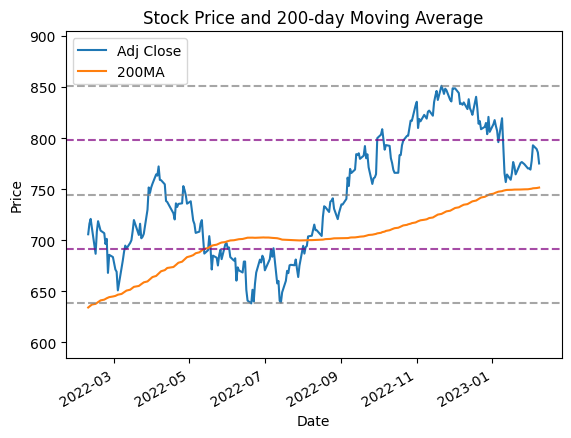

In [47]:
fig, ax = plt.subplots()
df.plot(y=['Adj Close', '200MA'], ax=ax)
ax.axhline(max_price, color='gray', linestyle='--', alpha=0.7)
ax.axhline(min_price, color='gray', linestyle='--', alpha=0.7)
ax.axhline(min_price + increment, color='purple', linestyle='--', alpha=0.7)
ax.axhline(min_price + 2* increment, color='gray', linestyle='--', alpha=0.7)
ax.axhline(min_price + 3* increment, color='purple', linestyle='--', alpha=0.7)
plt.title("Stock Price and 200-day Moving Average")
ax.set_ylim(min_price - increment, max_price + increment)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")

In [ ]:
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
fig = go.Figure()

In [ ]:
fig.add_shape(
        type='line',
        x0=df.index[0],
        y0=min_price,
        x1=df.index[-1],
        y1=min_price,
        yref='y',
        line=dict(
            color='gray',
            width=1,
            dash='dash'
        )
    )
fig.add_shape(
        type='line',
        x0=df.index[0],
        y0=min_price + increment,
        x1=df.index[-1],
        y1=min_price + increment,
        yref='y',
        line=dict(
            color='green',
            width=1,
            dash='dash'
        )
    )
fig.add_shape(
        type='line',
        x0=df.index[0],
        y0=min_price + 2 * increment,
        x1=df.index[-1],
        y1=min_price + 2 * increment,
        yref='y',
        line=dict(
            color='gray',
            width=1,
            dash='dash'
        )
    )
fig.add_shape(
        type='line',
        x0=df.index[0],
        y0=min_price + 3 * increment,
        x1=df.index[-1],
        y1=min_price + 3 * increment,
        yref='y',
        line=dict(
            color='green',
            width=1,
            dash='dash'
        )
    )
fig.add_shape(
        type='line',
        x0=df.index[0],
        y0=max_price,
        x1=df.index[-1],
        y1=max_price,
        yref='y',
        line=dict(
            color='gray',
            width=1,
            dash='dash'
        )
    )

fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close'], name='Stock Price', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['200MA'], name='200-day Moving Average', line=dict(color='red')))
fig.add_trace(go.Bar(x=df.index, y=df['distance'], name='Difference', marker=dict(color='green')))
fig.update_yaxes(range=[min_price - increment, max_price + increment])
fig.update_layout(title="Stock Price, 200-day Moving Average, and Difference")

fig.show()
